In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch import optim
from sklearn import preprocessing
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error

In [374]:
import matplotlib

In [371]:
pd = nb_setup.setup_pandas(escape_latex = False)

### Daten einlesen

In [2]:
rawdat = pd.read_csv('C:\\Users\\dusti\\iCloudDrive\\Studium WI\\WS2019\\KI\\rawdat.csv', sep = ';')

In [3]:
rawdat = rawdat[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTR','HS','AS','HST','AST']]

In [4]:
rawdat.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTR,HS,AS,HST,AST
0,Aston Villa,Wigan,0,2,A,A,11,14,5,7
1,Blackburn,Man City,0,2,A,A,17,8,9,5
2,Bolton,Sunderland,0,1,A,A,11,20,3,13
3,Chelsea,Hull,2,1,H,D,26,7,12,3
4,Everton,Arsenal,1,6,A,A,8,15,5,9


### Daten verarbeiten und kodieren

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
# Methode setzt Punkte für Heim und Auswärtsteam und erstellt neue Spalten
def windrawloseHomeAway(data):
    data = data[['HomeTeam', 'AwayTeam', 'FTR']]
    data['FTRH']= pd.Series(np.zeros(len(data['FTR'])))
    data['FTRA']= pd.Series(np.zeros(len(data['FTR'])))
    i = 0
    ftrH = 0
    ftrA = 0
    for row in data.itertuples():
        ftr = data.iloc[i]['FTR']
        if (ftr == 'H'):
            ftrH = 3
            ftrA = 0
        if (ftr == 'A'):
            ftrH = 0
            ftrA = 3
        if (ftr == 'D'):
            ftrH = 1
            ftrA = 1
        data.set_value(i,'FTRH', ftrH)
        data.set_value(i, 'FTRA', ftrA)
        i = i+1
    return data[['HomeTeam', 'AwayTeam', 'FTRH', 'FTRA','FTR']]
    

In [7]:
new_df = windrawloseHomeAway(rawdat)

C:\Users\dusti\Anaconda3\envs\DustinKI\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\dusti\Anaconda3\envs\DustinKI\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [8]:
homeP = new_df['FTRH']
awayP = new_df['FTRA']

In [9]:
# Dimensionalität richten
homeP= np.resize(homeP,(homeP.size, 1))
awayP = np.resize(awayP,(awayP.size,1))
print(homeP.shape)
print(awayP.shape)

(3800, 1)
(3800, 1)


#### Punkte zwischen 0 und 1 skalieren

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
homeP_scaled = min_max_scaler.fit_transform(homeP)

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
awayP_scaled = min_max_scaler.fit_transform(awayP)

In [12]:
df_scale_homeP = pd.DataFrame(homeP_scaled)
df_scale_awayP = pd.DataFrame(awayP_scaled)
new_df['SPH'] = df_scale_homeP
new_df['SPA'] = df_scale_awayP
new_df.head()

,HomeTeam,AwayTeam,FTRH,FTRA,FTR,SPH,SPA
0,Aston Villa,Wigan,0.0,3.0,A,0.0,1.0
1,Blackburn,Man City,0.0,3.0,A,0.0,1.0
2,Bolton,Sunderland,0.0,3.0,A,0.0,1.0
3,Chelsea,Hull,3.0,0.0,H,1.0,0.0
4,Everton,Arsenal,0.0,3.0,A,0.0,1.0


In [13]:
min_max_scaler.scale_

array([0.33333333])

In [14]:
new_df['SPH'][0]/min_max_scaler.scale_[0] == new_df['FTRH'][0]

True

In [17]:
new_df.head()

,HomeTeam,AwayTeam,FTRH,FTRA,FTR,SPH,SPA
0,Aston Villa,Wigan,0.0,3.0,A,0.0,1.0
1,Blackburn,Man City,0.0,3.0,A,0.0,1.0
2,Bolton,Sunderland,0.0,3.0,A,0.0,1.0
3,Chelsea,Hull,3.0,0.0,H,1.0,0.0
4,Everton,Arsenal,0.0,3.0,A,0.0,1.0


### Input und Targets generieren

In [173]:
input = []
target= []
for row in new_df.itertuples():
    inputdf = pd.DataFrame()
    inputdf_1 = pd.DataFrame()
    homeTeam = row.HomeTeam
    awayTeam = row.AwayTeam
    index = row.Index
    df_home = new_df[new_df['HomeTeam']==homeTeam]
    df_home = df_home.truncate(after= index)
    df_home.drop(index, inplace=True)
    inputdf['H'] = df_home.tail()['SPH']
    if len(inputdf.index) == 5:
        df_away = new_df[new_df['AwayTeam']==awayTeam]
        df_away = df_away.truncate(after= index)
        df_away.drop(index, inplace=True)
        inputdf_1['A']= df_away.tail()['SPA']
        if len(inputdf_1.index) == 5:
            inputdf['A']= inputdf_1['A'].values
            inputlist = inputdf.values.tolist()
            target_df = row.FTR
            input.append(inputlist)
            target.append(target_df)

In [174]:
len(input) == len(target)

True

In [175]:
# Aus den Targets einen 3-zeiligen Vektor machen
target_vector = []
for result in target:
    if result == 'H':
        data = [1.,0.,0.]
    elif result == 'D':
        data = [0.,1.,0.]
    else:
        data = [0.,0.,1.]
    target_vector.append(data)

In [161]:
len(input) == len(target_vector)

True

In [162]:
type(target_vector[0])

list

In [163]:
target_vector[0]

[0.0, 0.0, 1.0]

In [176]:
input[0]

[[0.0, 1.0],
 [0.0, 1.0],
 [0.3333333333333333, 1.0],
 [0.3333333333333333, 0.0],
 [1.0, 0.0]]

In [177]:
type(input[0])

list

In [136]:
#for df in input:
#    df = df.to_numpy()

### Daten in Test und Trainingsdaten teilen

In [151]:
from sklearn.model_selection import train_test_split

In [178]:
input_train, input_test, target_train, target_test = train_test_split(input, target_vector, test_size=0.20) 

In [214]:
input_train[0]

[[0.0, 0.0],
 [1.0, 0.0],
 [0.3333333333333333, 0.0],
 [0.3333333333333333, 0.0],
 [0.3333333333333333, 0.0]]

### Datensatz aus Input und Target erstellen

In [87]:
class TempDataset(Dataset):
    def __init__(self, input, target):
        self.input=input
        self.target=target
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.target[index]
        
        return x, y

In [180]:
#Trainingsdatensatz erstellen
training_set = TempDataset(input_train, target_train)

In [181]:
len(training_set)/len(target_vector)

0.8

In [182]:
len(input_train)

2832

In [380]:
# Trainingsdatensatz in richtige Form bringen
def mycollate(batch):
    input = torch.Tensor([item[0] for item in batch]).view(16,5,2).permute(1,0,2)
    target= torch.Tensor([item[1] for item in batch]).view(16,1,3).permute(1,0,2)
    return input, target

In [381]:
params = {'batch_size' : 16,
         'shuffle' : False,
         'num_workers' : 0,
         'collate_fn' : mycollate}

In [382]:
training_generator = DataLoader(training_set, **params)

In [383]:
x,y = next(iter(training_generator))
x.size()

torch.Size([5, 16, 2])

In [384]:
y.size()

torch.Size([1, 16, 3])

In [385]:
x.size()[1]==16

True

## LSTM-Netz errichten

In [393]:
BATCH_SIZE = params['batch_size']
NUM_LAYERS = 3

class LSTMnn(nn.Module):
    
    def __init__(self , input_size , hidden_size , output_size , 
                 batch_size = BATCH_SIZE , num_layers = NUM_LAYERS ) :
        super(LSTMnn, self).__init__()
        self.batch_size = batch_size
        # creation LSTM LAYER
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first = False)
        self.hidden = self.init_hidden()
        #Creation Linear Layer
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def init_hidden(self): # random Weights will be generated
        return (torch.rand(self.num_layers, self.batch_size, self.hidden_size),
               torch.rand(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input_seqence):
        out, _ = self.lstm(input_seqence, self.hidden)
        output = torch.sigmoid(self.linear(out[-1]))
        return output

In [398]:
# 20>hidden>9,6
lstm = LSTMnn(input_size=2, hidden_size=15, output_size=3, batch_size= BATCH_SIZE, num_layers=NUM_LAYERS)

In [399]:
# Fehlerfinktion und Lernfunktion 
loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr =0.03)

In [400]:
loss_memory= []
for epoch in range (10):
    for local_batch, local_labels in training_generator:
        lstm.zero_grad()
        if local_batch.size()[1] == 16:
            out = lstm(local_batch)
            loss = loss_function(out, local_labels)
            loss_memory.append(loss)
            loss.backward(retain_graph = True)
            optimizer.step()
    print('Fehler letzter Batch: {}'.format(loss.item()))

Fehler letzter Batch: 0.1980917900800705
Fehler letzter Batch: 0.19753947854042053
Fehler letzter Batch: 0.1977921575307846
Fehler letzter Batch: 0.19799688458442688
Fehler letzter Batch: 0.19815649092197418
Fehler letzter Batch: 0.19829078018665314
Fehler letzter Batch: 0.19838325679302216
Fehler letzter Batch: 0.19838446378707886
Fehler letzter Batch: 0.19852273166179657
Fehler letzter Batch: 0.198472797870636


In [391]:
lstm(x)

tensor([[0.4615, 0.2446, 0.2926],
        [0.4609, 0.2458, 0.2940],
        [0.4616, 0.2443, 0.2923],
        [0.4595, 0.2461, 0.2949],
        [0.4618, 0.2440, 0.2919],
        [0.4612, 0.2456, 0.2937],
        [0.4613, 0.2448, 0.2929],
        [0.4612, 0.2453, 0.2934],
        [0.4844, 0.2353, 0.2740],
        [0.4609, 0.2459, 0.2941],
        [0.4601, 0.2458, 0.2944],
        [0.4597, 0.2452, 0.2940],
        [0.4596, 0.2464, 0.2952],
        [0.4674, 0.2417, 0.2873],
        [0.4614, 0.2449, 0.2929],
        [0.4617, 0.2448, 0.2928]], grad_fn=<SigmoidBackward>)

In [368]:
from ipypublish import nb_setup

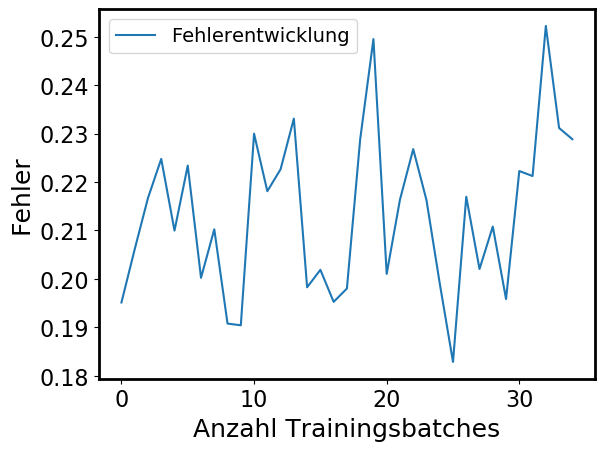

In [392]:
y = [item.item() for item in loss_memory]
x = range(len(loss_memory))
plt = nb_setup.setup_matplotlib(output =('png','png'))
plt.plot(x, y, label = 'Fehlerentwicklung')
plt.ylabel(r'Fehler')
plt.xlabel(r'Anzahl Trainingsbatches')
plt.legend();